## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#To get id,  Enable link sharing for the file you want to transfer. Copy the link
download = drive.CreateFile({'id': '1zJG9yNfFKBpFXIgWyXIjMAR7vnoPAxSq'})
download.GetContentFile('facial-keypoints-data.zip') # File Name

!unzip facial-keypoints-data.zip

Archive:  facial-keypoints-data.zip
   creating: facial-keypoints/
   creating: facial-keypoints/data/
  inflating: facial-keypoints/data/gt.csv  
   creating: facial-keypoints/data/images/
  inflating: facial-keypoints/data/images/00000.jpg  
  inflating: facial-keypoints/data/images/00001.jpg  
  inflating: facial-keypoints/data/images/00002.jpg  
  inflating: facial-keypoints/data/images/00003.jpg  
  inflating: facial-keypoints/data/images/00004.jpg  
  inflating: facial-keypoints/data/images/00005.jpg  
  inflating: facial-keypoints/data/images/00006.jpg  
  inflating: facial-keypoints/data/images/00007.jpg  
  inflating: facial-keypoints/data/images/00008.jpg  
  inflating: facial-keypoints/data/images/00009.jpg  
  inflating: facial-keypoints/data/images/00010.jpg  
  inflating: facial-keypoints/data/images/00011.jpg  
  inflating: facial-keypoints/data/images/00012.jpg  
  inflating: facial-keypoints/data/images/00013.jpg  
  inflating: facial-keypoints/data/images/00014.jpg  


In [0]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
### Useful routines for preparing data
from sklearn import preprocessing
from numpy import array, zeros
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import os


def load_imgs_and_keypoints(dirname='facial-keypoints/data'):
    # Write your code for loading images and points here

    IMG_SIZE = 100
    IMG_CHANNEL = 3
    
    points = pd.read_csv(dirname +'/gt.csv')
    file_name = points['filename']
    points = points.drop(['filename'], axis=1).values
    
    num_images = points.shape[0]
    images = zeros((num_images, IMG_SIZE, IMG_SIZE, IMG_CHANNEL))
    final_points = zeros((points.shape))

    path_img = os.path.join(dirname,"images/")
    
    for i in range(num_images):
        img = imread(path_img + file_name[i])
        images[i, :] = resize(img, (IMG_SIZE, IMG_SIZE, IMG_CHANNEL))

        height, width = img.shape[0], img.shape[1]
        image_points = points[i,:]

        resized_points = np.zeros((image_points.shape))
        width_points = image_points[0::2] / width - 0.5
        height_points = image_points[1::2] / height - 0.5
        
        resized_points[::2] = width_points
        resized_points[1::2] = height_points
        final_points[i,:] = resized_points[:]
        
    return images, final_points
        
imgs, points = load_imgs_and_keypoints()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

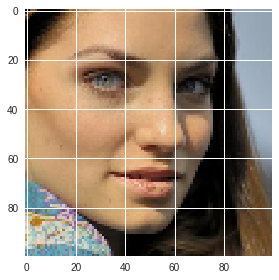

In [26]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

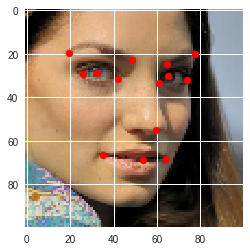

In [27]:

# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle
import matplotlib.pyplot as plt


def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    plt.imshow(img, cmap='gray')
    for i in range(0,28,2):
      plt.scatter((points[i]+0.5)*100, (points[i+1]+0.5)*100, color='red')
       
visualize_points(imgs[0], points[0])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

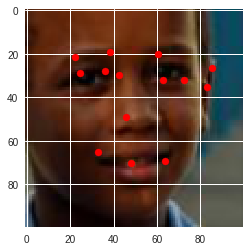

In [29]:
def flip_img(img, points):
    # Write your code for flipping here
    flip_img = np.fliplr(img)
    
    for i in range(0,28,2):
        points[i] = -points[i]
    
    return flip_img, points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
# Write your code here
aug_imgs_train, aug_points_train = np.zeros(imgs_train.shape), np.zeros(points_train.shape)

for i in range(imgs_train.shape[0]):
    aug_img, aug_point = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train[i, :] = aug_img
    aug_points_train[i, :] = aug_point
  

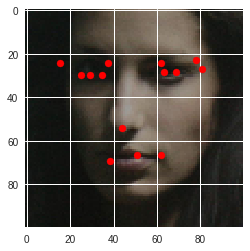

In [7]:
visualize_points(aug_imgs_train[49], aug_points_train[49])

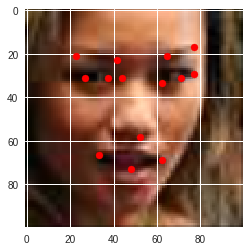

In [8]:
visualize_points(aug_imgs_train[51], aug_points_train[51])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [0]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation)

# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [33]:
batch_size = 32
num_classes = 28
epochs = 12
input_shape = (100, 100, 3)

# Define here your model

model = Sequential()
model.add(Conv2D(16,(3,3),input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(36,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
activation_14 (Activation)   (None, 98, 98, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 36)        5220      
_________________________________________________________________
activation_15 (Activation)   (None, 47, 47, 36)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 36)        0         
__________

In [34]:
model_history = model.fit(aug_imgs_train, aug_points_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          verbose=1,
          validation_data=(imgs_val, points_val))

Train on 5400 samples, validate on 600 samples
Epoch 1/12
5400/5400 [==============================] - 6s 1ms/step - loss: 0.0214 - acc: 0.5643 - val_loss: 0.0646 - val_acc: 0.0017
Epoch 2/12
5400/5400 [==============================] - 5s 952us/step - loss: 0.0038 - acc: 0.8020 - val_loss: 0.0651 - val_acc: 0.0017
Epoch 3/12
5400/5400 [==============================] - 5s 950us/step - loss: 0.0035 - acc: 0.8569 - val_loss: 0.0658 - val_acc: 0.0017


Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [39]:
# Example of output

points_test = model.predict(imgs_val)

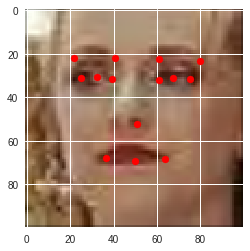

In [41]:
visualize_points(imgs_val[1], points_test[1])

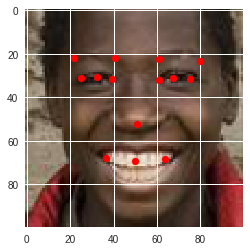

In [43]:
visualize_points(imgs_val[6], points_test[6])

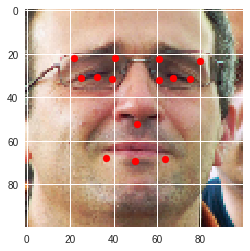

In [44]:
visualize_points(imgs_val[10], points_test[10])